<p><a href="https://colab.research.google.com/github/compgeog/choropleth-tradeoffs/blob/main/explore_choropleth_results.ipynb" target="_blank"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a></p>

# Tradeoffs for Choropleth Classifications: Exploring the Results


This notebook explains how to explore the tradeoffs for the choropleth classifications, using the 1959 Illinois farm products data as an example. In a separate notebook, all the classifications (more than 3 million) classifications are evaluated and here we load the results from that computation and illustrate how to use that to visualize the tradeoffs and draw the maps.  

The following two cells contain commands that are used to install necessary libraries. They do not need to be run every time. 

In [ ]:
!git clone https://github.com/gisalgs/geom
!git clone https://github.com/gisalgs/spatialanalysis
!git clone https://github.com/compgeog/cgl

In [ ]:
!pip install matplotlib

The following cell makes sure the necessary libraries and modules are imported to run the experiments in the rest of this notebook.

In [3]:
from geom.shapex import *
from spatialanalysis.moransi2 import *
from cgl.cgl.util.get_adjacency_matrix import *
from cgl.cgl.util.draw_polygons_shapex import *
from cgl.cgl.util.get_attribute_by_name import *
from cgl.cgl.util.evaluate_all import *
from cgl.cgl.util.pareto_ranking import *
from cgl.cgl.util.parallel_coordinates import *
from cgl.cgl.util.xcolorbrewer import *
from cgl.cgl.util.breakpoints2 import *

import time
import random

import urllib.request as request

import json

import matplotlib.pyplot as plt
%matplotlib inline

# Map Data

In this tutorial, we use the data of 1959 Illinois farm products. This data set has been used in many cartographic studies such as [this](https://www.tandfonline.com/doi/full/10.1111/1467-8306.9303005). The data is converted to a GeoJSON file and can be loaded directly from its [github source](https://raw.githubusercontent.com/compgeog/choropleth-tradeoffs/main/data/il/il.geojson).

In [4]:
url_il_data = 'https://raw.githubusercontent.com/compgeog/choropleth-tradeoffs/main/data/il/il.geojson'
with request.urlopen(url_il_data) as response:
    shp = json.loads(response.read())

all_features = shp['features']

We need to get the bounds of the coordinates:

In [5]:
envelopes = get_feature_envelopes(all_features) # list of [xmin, ymin, xmax, ymax]
# geom_bounds = [min([p[0] for p in envelopes]), min([p[1] for p in envelopes]), max([p[2] for p in envelopes]), max([p[3] for p in envelopes])]
geom_bounds = {
    'xmin': min([p[0] for p in envelopes]), 
    'ymin': min([p[1] for p in envelopes]), 
    'xmax': max([p[2] for p in envelopes]), 
    'ymax': max([p[3] for p in envelopes])
}

geom_bounds # [xmin, ymin, xmax, ymax]

{'xmin': 115181.34624100267,
 'ymin': 4095659.5064726495,
 'xmax': 455924.96284696716,
 'ymax': 4712750.858482279}

Let's quickly draw a map to make sure the geometries are loaded correctly.

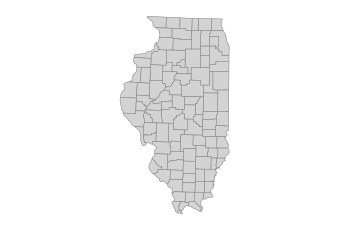

In [6]:
draw_shape(all_features)
plt.axis('off')
plt.axis('equal')
plt.show()

With the data loaded, we need to obtain the adjacency matrix (list), all the values of the attribute called FARM_PROD, and all the unique values (sorted). We also set the number of classes for this tutorial to 5. 

In [7]:
attrname = 'FARM_PROD'

adjacency_list = adjacency_matrix(all_features, output='L')
all_values = get_shp_attribute_by_name(all_features, attrname)
all_areas = get_shp_attribute_by_name(all_features, 'AREA')
unique_values = list(set(all_values))
unique_values.sort()

numclass = 5  # 

m = len(all_values)     # number of all values in data
n = len(unique_values)  # number of unique values in data
print(n, m, min(unique_values), max(unique_values))

101 102 15.57 155.3


We can also show a histogram of the data.

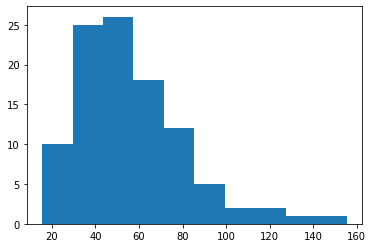

In [8]:
plt.hist(all_values)
plt.show()

# Defining a classification

A Python class called `Intervals` is defined in the [classify.py](https://github.com/compgeog/cgl/blob/master/cgl/util/classify.py) that will be cloned here (see the beginning of this tutorial). There are multiple ways to create a classification. Below is an example using a set of lower and upper bounds:

In [9]:
intervals = Intervals()
intervals_bounds = [ [15.57, 41.20], [41.21, 60.66], [60.67, 77.29], [77.30, 100.10], [100.10, 155.30] ]
intervals.set_classes(intervals_bounds)
intervals

[15.57 - 41.2], [41.21 - 60.66], [60.67 - 77.29], [77.3 - 100.1], [100.1 - 155.3]

# Drawing a choropleth map using a set of intervals

We can draw a choropleth map using the classification scheme created from the above section. 

We first need to calculate the geometry bounds of the map, which will be used later.

In [10]:
xmin, ymin, xmax, ymax = geom_bounds['xmin'], geom_bounds['ymin'], geom_bounds['xmax'], geom_bounds['ymax']

We draw the map using the intervals stored in `intervals`:

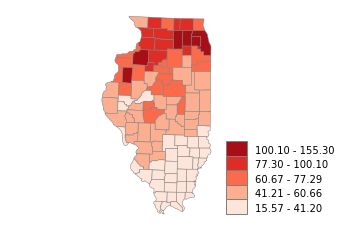

In [11]:
# get the classes using the break points in intervals
classes = [intervals.get_class(v) for v in all_values]

# get the color scheme
colors = get_colorbrewer_specs('Reds', numclass)

# set up the canvas (ax0 is used in rect_legend)
_, ax0 = plt.subplots()

draw_shape(all_features, classes, colors)

box_w = (geom_bounds['xmax']-geom_bounds['xmin'])/5  # a fraction of the total with
box_h = box_w*2/3      # slightly smaller than the width
label_xgap = box_w / 3
label_ygap = box_h * 0.2

rect_legend(xmax*1.1, ymin, box_w, box_h, label_xgap, ax0, colors, ygap=label_ygap, edgecolor='grey', intervals=intervals, num_digits=2)

plt.axis('off')
plt.axis('equal')
plt.show()


# Evaluating intervals

Each classification scheme can be evaluated using different criteria. We implemented four specific criteria in this tutorial. Specifically, they are GVF, OAI, Moran's I, and BAI (see [Armstrong, Xiao, Bennett 2003](https://www.tandfonline.com/doi/full/10.1111/1467-8306.9303005) for detail). 

To evaluate the classification scheme in an `Intervals` object, we first get the class assignment of each spatial unit in the data:

In [12]:
classes = [intervals.get_class(v) for v in all_values]

The following four code cells evaluates the four criteria respectively.

In [13]:
gvf2(classes, all_values, numclass)

0.9243214176664973

In [14]:
oai(classes, all_values, all_areas, numclass)

0.7217901107071523

In [15]:
class_counts = [ len([i for i in classes if i==j]) for j in range(numclass) ] 
class_means = [ sum([all_values[i] for i in range(m) if classes[i]==j])/float(class_counts[j])
                for j in range(numclass) ]
means = [ class_means[i] for i in classes ]
moransi2(means, adjacency_list)

0.7309683036965045

In [16]:
bai(adjacency_list, all_values, classes)

0.7386362917660153

Now we write two functions to wrap the code so we can use them repeatedly later. We assume the following variables available:

-  `all_values`
-  `unique_values`
-  `all_areas`
-  `numclass`

In [17]:
# given a set of intervals, returns a tuple of the four criteria values: GVF, OAI, Moran's I, BAI 
def eval_intervals(_intervals):
    classes = [_intervals.get_class(i) for i in all_values]
    class_counts = [ len([i for i in classes if i==j]) for j in range(numclass) ] 
    class_means = [ sum([all_values[i] for i in range(m) if classes[i]==j])/float(class_counts[j])
                    for j in range(numclass) ]
    means = [ class_means[i] for i in classes ]
    o1 = gvf2(classes, all_values, numclass)
    o2 = oai(classes, all_values, all_areas, numclass)
    o3 = moransi2(means, adjacency_list)
    o4 = bai(adjacency_list, all_values, classes)
    return o1, o2, o3, o4

# given a set of break points, returns a tuple that contains the intervals and a tuple of the four criteria values
def eval_break_points(break_points):
    intervals = Intervals()
    intervals.set_classes_by_data2(list(break_points), unique_values)
    return intervals, eval_intervals(intervals)

## Exploring the classifications

There are 102 spatial units in the data and there are 101 unique values. If we choose to make choropleth maps using 5 classes, this leads to more than 3 million possible classifications (3,921,225 to be exact). In a separate notebook, we exhaustively computed all the classifications and two sets of results are saved so we can use them without having to go through the computation again.

- Four classifications where each exhibits the best value of one criterion.
- A set of 10,000 samples from all the classifications.

The first set of results (referred to as *extremes* here) is saved as a JSON file and can be found in the github repo at [here](https://raw.githubusercontent.com/compgeog/choropleth-tradeoffs/main/extremes_results_5classes_il_farm_prod.json).  It can be retrieved directly and then the bounds will be used to construct the `Intervals` objects:

In [18]:
url_extremes = 'https://raw.githubusercontent.com/compgeog/choropleth-tradeoffs/main/extremes_results_5classes_il_farm_prod.json'
with request.urlopen(url_extremes) as response:
    extremes_js = json.loads(response.read())

In [19]:
extremes = []
for e in extremes_js:
    intervals = Intervals()
    intervals.set_classes(extremes_js[e][0])
    extremes.append([intervals, extremes_js[e][1]])

In [20]:
extremes

[[[15.57 - 41.2], [45.4 - 60.66], [62.06 - 77.29], [79.66 - 100.1], [111.8 - 155.3],
  [0.93133839170431,
   0.7248757193031732,
   0.756850123831985,
   0.7386362917660153]],
 [[15.57 - 41.2], [45.4 - 55.44], [56.35 - 71.61], [72.76 - 100.1], [111.8 - 155.3],
  [0.9255424539452779,
   0.7302258224073982,
   0.7795877972237811,
   0.7036454940453977]],
 [[15.57 - 32.69], [33.26 - 41.2], [45.4 - 57.4], [57.49 - 71.61], [72.76 - 155.3],
  [0.8308518898371546,
   0.6298383413799542,
   0.8624986397790059,
   0.5338650205865424]],
 [[15.57 - 36.24], [37.57 - 49.38], [50.11 - 66.32], [67.04 - 96.37], [96.78 - 155.3],
  [0.913668495355815,
   0.6960041156585309,
   0.7211905404181319,
   0.7760082978629208]]]

In [21]:
# print optimum values
objective_names = [ 'GVF', 'OAI', 'Moran\'s I', 'BAI' ]

for i in range(len(extremes)):
    res = extremes[i]
    print(objective_names[i], '=', res[1][i])

GVF = 0.93133839170431
OAI = 0.7302258224073982
Moran's I = 0.8624986397790059
BAI = 0.7760082978629208


The second set of results is also saved in a JSON file and can be directly loaded from the repo:

In [22]:
# loading the json file from githut repo
url_samples = 'https://raw.githubusercontent.com/compgeog/choropleth-tradeoffs/main/sample_results_5classes_il_farm_prod.json'
with request.urlopen(url_samples) as response:
    sample_results_js_url = json.loads(response.read())
    
sample_results = []
for e in sample_results_js_url['samples']:
    intervals = Intervals()
    intervals.set_classes(e[0])
    sample_results.append([intervals, e[1]])

This results need to be sorted using the Pareto ranking. This will help us identify the classifications that dominate the others in the sample. The following code sorts the samples. This may take a minute or so depending on the speed of the computer.

In [23]:
t3 = time.time()

sample_objs = [res[1] for res in sample_results]
sample_ranks = pareto_ranking(sample_objs, minimize=False, verbose=True)

t4 = time.time()
print('total time to rank is', t4-t3, 'seconds')

Remaining: 0/10000           
total time to rank is 66.19814920425415 seconds


Let's find what are the best criteria values in these samples (these are the extremes in the samples):

In [24]:
sample_bests = []

for i in range(4):
    os = [x[1][i] for x in sample_results]
    osmax = max(os)
    idx = os.index(osmax)
    sample_bests.append(idx)
    
sample_bests_objs = [sample_results[sample_bests[i]] for i in range(4)]

In [25]:
for i in range(len(sample_bests_objs)):
    res = sample_bests_objs[i]
    print(objective_names[i], '=', res[1][i])

GVF = 0.9286099277317483
OAI = 0.7290910880047992
Moran's I = 0.8468159437594118
BAI = 0.7573792161302357


Compared with the extremes, these values are all smaller than their extreme counterpart (since they are just random samples).

We now separate the nondominated and dominated classifications in the samples:

In [26]:
nondominated = [sample_results[i] for i in range(len(sample_ranks)) if sample_ranks[i]==1]
dominated = [sample_results[i] for i in range(len(sample_ranks)) if sample_ranks[i]!=1]

The number of nondominated solutions varies among different samples.

In [27]:
len(nondominated)

60

In [28]:
nondominated[0]

[[15.57 - 46.13], [47.21 - 57.59], [58.5 - 68.25], [68.45 - 76.43], [77.29 - 155.3],
 [0.8490031356664478, 0.6521144008385, 0.8099922767770901, 0.5997957157222998]]

## Parallel coordinates plot showing the tradeoffs

Now we make a parallel coordinates plot to show the four extreme solutions, the nondominated and dominated solutions in the samples.

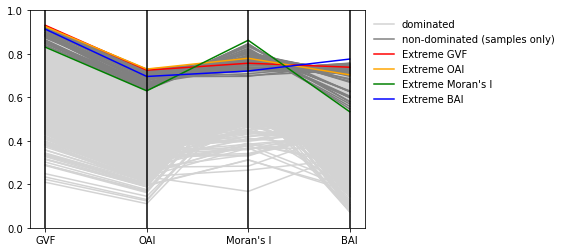

In [29]:
objective_names = [ 'GVF', 'OAI', 'Moran\'s I', 'BAI' ]
bounds = [[0, 1] for i in range(4)]

best_objs = [v[1] for v in extremes] 

nondominated_objs = [res[1] for res in nondominated]
dominated_objs = [res[1] for res in dominated]

colors = ['lightgrey']*len(dominated) + ['grey']*len(nondominated) + ['red', 'orange', 'green', 'blue']
legend_labels = ['dominated']*len(dominated) + ['non-dominated (samples only)']*len(nondominated) \
    + ['Extreme GVF', 'Extreme OAI', 'Extreme Moran\'s I', 'Extreme BAI']

pcpx(dominated_objs + nondominated_objs + best_objs, 
     bounds=bounds, style=colors, labels=objective_names, 
     legend_labels=legend_labels, legend_loc=2, bbox_to_anchor=(1, 1))

plt.show()

# Mapping

Now we draw maps with different classification schemes together. Maps in the first row exhibit the four extreme values. Maps in the second row are based on the nondominated classifications from the samples, while those in the bottom row are from dominated classifications. 


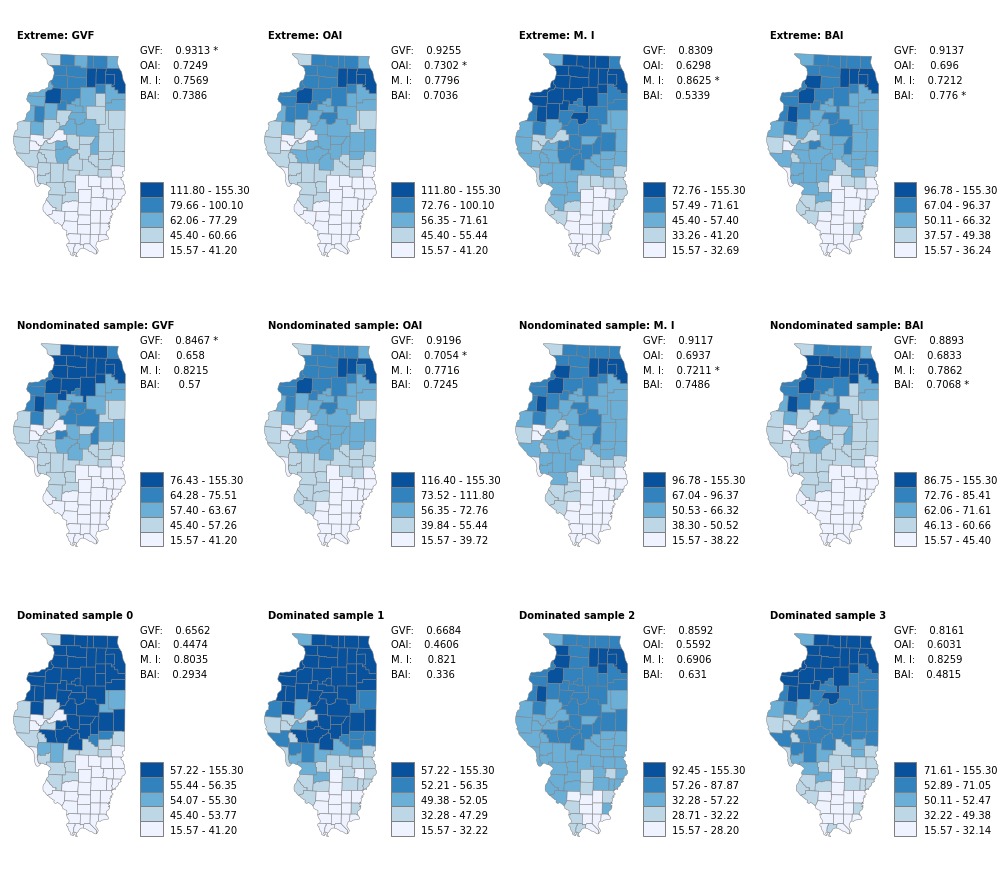

In [30]:
fig, ax2 = plt.subplots(3, 4, sharey=True, sharex=True)
fig.subplots_adjust(wspace=0)
fig.subplots_adjust(hspace=0)
fig.set_figheight(16)
fig.set_figwidth(18)

colors = get_colorbrewer_specs('Blues', numclass)
objective_names = [ 'GVF', 'OAI', 'M. I', 'BAI' ]

# some parameters to specify the legend box
box_w = (xmax-xmin)/5  # a fraction of the total with
box_h = box_w*2/3      # slightly smaller than the width
label_xgap = box_w / 3
label_ygap = box_h * 0.2

for axes in ax2:
    for ax in axes:
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_frame_on(False)  

for j in range(4):
    ax = ax2[0, j]
    ax.set_xlim(xmin, xmax)
    ax.set_ylim(ymin, ymax)
    ax.set_aspect(1)
    intervals = extremes[j][0]
    classes = [intervals.get_class(i) for i in all_values] 
    draw_shape(all_features, classes, colors, axis=ax)
    rect_legend(xmax*1.1, ymin, box_w, box_h, label_xgap, ax, colors, ygap=label_ygap, edgecolor='grey', intervals=intervals, num_digits=2)
    objs = extremes[j][1]
    ax.text(xmin*1.1, ymax+box_h, 'Extreme: {}'.format(objective_names[j]), weight='bold')
    for i in range(4):
        ax.text(xmax*1.1, ymax-i*box_h, '{}:{:10.4} {}'.format(objective_names[i], objs[i], '*' if i==j else ''))

four_maps = random.sample(nondominated, 4)

for j in range(4):
    ax = ax2[1, j]
    ax.set_xlim(xmin*0.84, xmax*1.7)
    ax.set_ylim(ymin*0.97, ymax*1.03)
    ax.set_aspect(1)
    intervals = four_maps[j][0]
    classes = [intervals.get_class(i) for i in all_values] 
    draw_shape(all_features, classes, colors, axis=ax)
    rect_legend(xmax*1.1, ymin, box_w, box_h, label_xgap, ax, colors, ygap=label_ygap, edgecolor='grey', intervals=intervals, num_digits=2)
    objs = four_maps[j][1]
    ax.text(xmin*1.1, ymax+box_h, 'Nondominated sample: {}'.format(objective_names[j]), weight='bold')
    for i in range(4):
        ax.text(xmax*1.1, ymax-i*box_h, '{}:{:10.4} {}'.format(objective_names[i], objs[i], '*' if i==j else ''))

four_maps2 = random.sample(dominated, 4)

for j in range(4):
    ax = ax2[2, j]
    ax.set_xlim(xmin*0.84, xmax*1.7)
    ax.set_ylim(ymin*0.97, ymax*1.03)
    ax.set_aspect(1)
    intervals = four_maps2[j][0]
    classes = [intervals.get_class(i) for i in all_values] 
    draw_shape(all_features, classes, colors, axis=ax)
    rect_legend(xmax*1.1, ymin, box_w, box_h, label_xgap, ax, colors, ygap=label_ygap, edgecolor='grey', intervals=intervals, num_digits=2)
    objs = four_maps2[j][1]
    ax.text(xmin*1.1, ymax+box_h, 'Dominated sample {}'.format(j), weight='bold')
    for i in range(4):
        ax.text(xmax*1.1, ymax-i*box_h, '{}:{:10.4}'.format(objective_names[i], objs[i]))


plt.show()